In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import subplots
from statsmodels.api import OLS, add_constant
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV


### Problem 8:

(a) Generate random numbers for X and e

(b) Generate response as polynomial degree 3 of X

(c) Using stepwise selection, X, X_2, X_3, X_8, X_9 is selected

In [88]:
np.random.seed(100)
X = np.random.normal(loc=0, scale=10, size=100)

np.random.seed(101)
e = np.random.normal(loc=0, scale=10, size=100)

print(X[:5])
print(e[:5])

beta_0, beta_1, beta_2, beta_3 = 1, 1, 1, 1
y = [beta_0 + beta_1 * (X[i] ** 1) + beta_2 * (X[i] ** 2) + beta_3 * (X[i] ** 3) + e[i] for i in range(len(X))]

print(y[:5])


[-17.49765473   3.42680403  11.53035803  -2.52436037   9.81320787]
[27.06849839  6.28132709  9.07969446  5.03825754  6.51117948]
[-5040.481807709409, 62.692028388329256, 1687.5105788746287, -6.1999295828459005, 1058.6260184729974]


<Axes: >

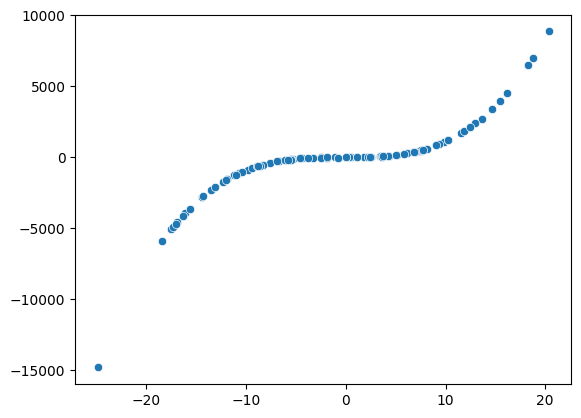

In [89]:
sns.scatterplot(x=X, y=y)

In [90]:
df = pd.DataFrame({'X': X})
for i in range(2, 11):
    df[f'X_{i}'] = df['X'] ** i

df = add_constant(df)
df.head()

,const,X,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,1.0,-17.497655,306.167921,-5357.220572,93738.795892,-1.640209e+06,2.869981e+07,-5.021794e+08,8.786962e+09,-1.537512e+11,2.690286e+12
1,1.0,3.426804,11.742986,40.240911,137.897717,4.725485e+02,1.619331e+03,5.549130e+03,1.901578e+04,6.516335e+04,2.233020e+05
2,1.0,11.530358,132.949156,1532.951370,17675.478134,2.038046e+05,2.349940e+06,2.709565e+07,3.124225e+08,3.602344e+09,4.153631e+10
3,1.0,-2.524360,6.372395,-16.086222,40.607421,-1.025078e+02,2.587665e+02,-6.532200e+02,1.648963e+03,-4.162576e+03,1.050784e+04
4,1.0,9.813208,96.299049,945.002582,9273.506779,9.100285e+04,8.930299e+05,8.763488e+06,8.599793e+07,8.439155e+08,8.281519e+09


In [91]:
model = OLS(y, df)
result = model.fit()
ols = result.predict(df)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.296e+05
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          3.14e-211
Time:                        16:49:37   Log-Likelihood:                -370.08
No. Observations:                 100   AIC:                             762.2
Df Residuals:                      89   BIC:                             790.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0406      2.323      0.448      0.655      -3.576       5.657
X              1.2579      0.726      1.734      0.086      -0.184       2.699
X_2            0.9378      0.167      5.608      0.000       0.605       1.270
X_3            0.9924      0.021     47.252      0.000       0.951       1.034
X_4            0.0015      0.003      0.476      0.635      -0.005       0.008
X_5         8.106e-05      0.000      0.437      0.663      -0.000       0.000
X_6        -6.806e-06   2.07e-05     -0.329      0.743   -4.79e-05    3.43e-05
X_7        -3.203e-07   6.21e-07     -0.516      0.607   -1.55e-06    9.13e-07
X_8         9.868e-09   5.67e-08      0.174      0.862   -1.03e-07    1.23e-07
X_9         3.965e-10   6.98e-10      0.568      0.571    -9.9e-10    1.78e-09
X_10       -1.624e-12   5.33e-11     -0.030      0.976   -1.07e-10    1.04e-10
==============================================================================
Omnibus:                        1.238   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.275
Skew:                           0.188   Prob(JB):                        0.529
Kurtosis:                       2.594   Cond. No.                     2.06e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
pred = result.predict(df)
((pred - y)**2).mean()

95.93444674889668

In [86]:
sfs = SequentialFeatureSelector(
    skl.LinearRegression(),
    k_features=5,
    forward=True,
    scoring='neg_mean_squared_error',
    cv=None
    )
selected_features = sfs.fit(df, y)
selected_features.k_feature_names_

('X', 'X_2', 'X_3', 'X_8', 'X_9')

In [87]:
model = skl.LinearRegression()
cv = skm.KFold(n_splits=5)

rfecv = RFECV(estimator=model, step=1, scoring='neg_mean_squared_error', cv=cv)
rfecv.fit(df, y)

selected_features = rfecv.support_
selected_feature_names = df.columns[selected_features]
print(selected_feature_names)

Index(['X', 'X_2', 'X_3', 'X_4', 'X_5'], dtype='object')


In [57]:
lasso = skl.Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = skm.GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df, y)

best_lasso = grid_search.best_estimator_
best_lasso.fit(df, y)

y_pred = best_lasso.predict(df)
test_mse = mean_squared_error(y, y_pred)

print(best_lasso.coef_)
print(f'Best alpha: {grid_search.best_params_["alpha"]}')
print(f'Test MSE: {test_mse:.3f}')

[ 0.00000000e+00  9.67330495e-01  8.75176067e-01  9.92354449e-01
  1.40825774e-03  5.33420769e-05 -3.06346447e-06 -8.97609147e-08
 -9.89483350e-10  2.48569405e-11  3.82761110e-12]
Best alpha: 10.0
Test MSE: 108.709


### Problem 9:

(a) Split the data into train and test set

(b) Fit linear regression on train set and test error: 1492433

(c) Ridge regression cross-validation and test error: 1478572 (alpha=10)

(d) Lasso regression cross-validation and test error: 1477249 (alpha=10)

(e) PCR regression cross-validation and test error: 1492443 (components=18)

In [58]:
College = load_data('College')
College.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [59]:
X = College.drop(columns='Apps')
X['Private'] = X['Private'].map({'No': 0, 'Yes': 1})
X = add_constant(X)
y = College['Apps']

X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=42)
model = OLS(y_train, X_train).fit()
pred = model.predict(X_test)
((pred - y_test)**2).mean()

1492443.379039793

In [15]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Apps   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     514.4
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:51:43   Log-Likelihood:                -5167.8
No. Observations:                 621   AIC:                         1.037e+04
Df Residuals:                     603   BIC:                         1.045e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -58.9802    439.540     -0.134      

In [46]:
ridge = skl.Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = skm.GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
best_ridge.fit(X_train, y_train)

y_pred = best_ridge.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print(f'Best alpha: {grid_search.best_params_["alpha"]}')
print(f'Test MSE: {test_mse:.3f}')


Best alpha: 10.0
Test MSE: 1478572.811


In [45]:
lasso = skl.Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = skm.GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_lasso = grid_search.best_estimator_
best_lasso.fit(X_train, y_train)

y_pred = best_lasso.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print(f'Best alpha: {grid_search.best_params_["alpha"]}')
print(f'Test MSE: {test_mse:.3f}')

Best alpha: 10.0
Test MSE: 1477249.003


In [63]:
def create_pipeline(n_components):
    return Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('regression', skl.LinearRegression())
    ])

n_components_range = range(1, X_train.shape[1] + 1)

best_n_components = None
best_score = float('inf')

for n_components in n_components_range:
    pipeline = create_pipeline(n_components)
    scores = skm.cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    
    if mean_score < best_score:
        best_score = mean_score
        best_n_components = n_components

best_pipeline = create_pipeline(best_n_components)
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print(f'Best number of components: {best_n_components}')
print(f'Test MSE: {test_mse:.3f}')

Best number of components: 18
Test MSE: 1492443.379
